In [50]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
from einops import rearrange
from kornia.geometry import ImageRegistrator, homography_warp


In [4]:
def listfiles(folder, regex=None):
    """Return all files with the given regex in the given folder structure"""
    for root, folders, files in os.walk(folder):
        for filename in folders + files:
            if regex is None:
                yield os.path.join(root, filename)
            elif re.findall(regex, os.path.join(root, filename)):
                yield os.path.join(root, filename)

In [6]:
fps = sorted(listfiles('/data/estorrs/sandbox/mushroom/data/test_classes/', regex=r'.npy$'))
fps

['/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U2.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U3.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U4.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U5.npy']

In [7]:
sid_to_masks = {}
for fp in fps:
    sid = fp.split('/')[-1].split('.')[0]
    sid_to_masks[sid] = torch.tensor(np.load(fp), dtype=torch.bool)
sid_to_masks.keys()

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [8]:
bbox = (300,1800,200,1700)

sid_to_masks = {k:v[:, bbox[0]:bbox[1], bbox[2]:bbox[3]] for k, v in sid_to_masks.items()}

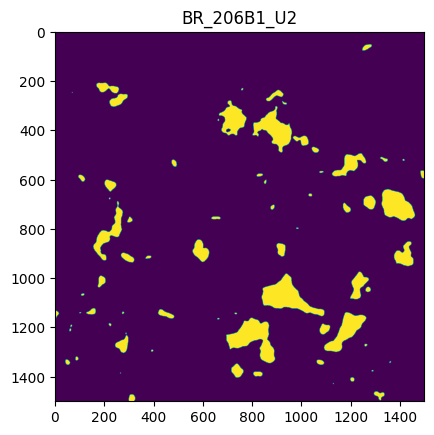

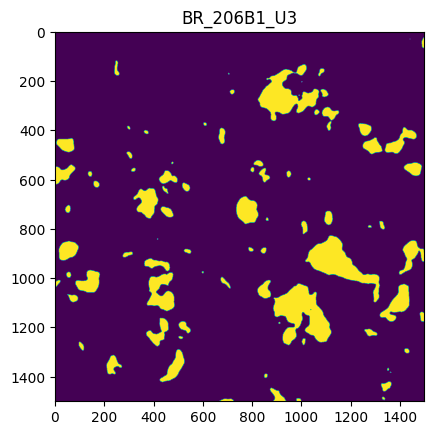

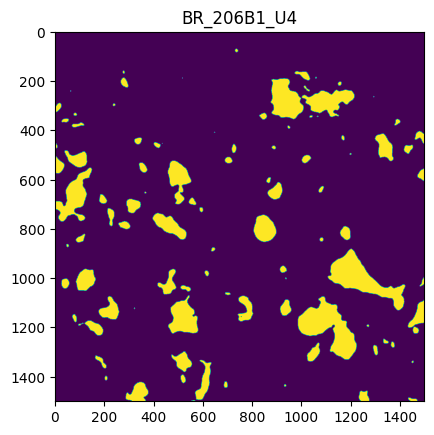

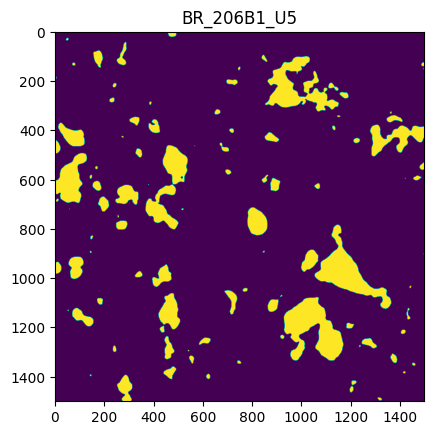

In [13]:
for k, v in sid_to_masks.items():
    plt.imshow(v[0])
    plt.title(k)
    plt.show()

In [14]:
def labeled_image_from_masks(masks, order=None):
    if order is None:
        order = np.arange(masks.shape[0])
    new = torch.zeros((masks.shape[-2], masks.shape[-1]), dtype=torch.long)
    for i in order:
        new[masks[i]] = i + 1
    return new

In [15]:
# bgn, il7r, epcam
order = [2, 0, 1]
sid_to_labeled = {k:labeled_image_from_masks(v, order=order)
                  for k, v in sid_to_masks.items()}

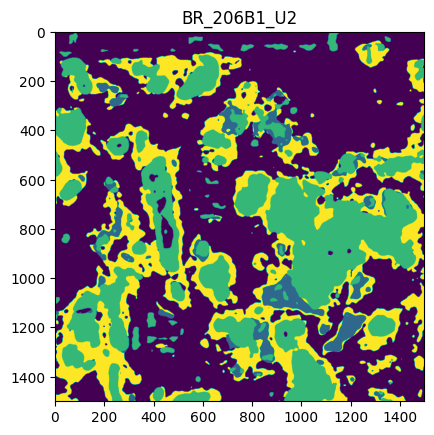

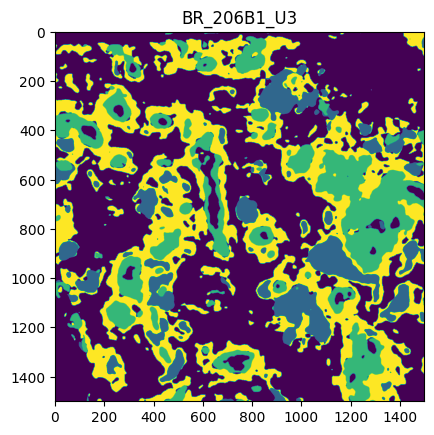

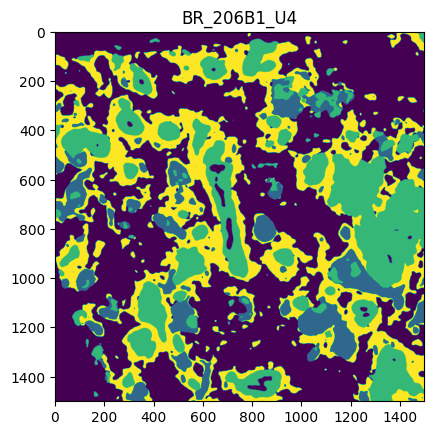

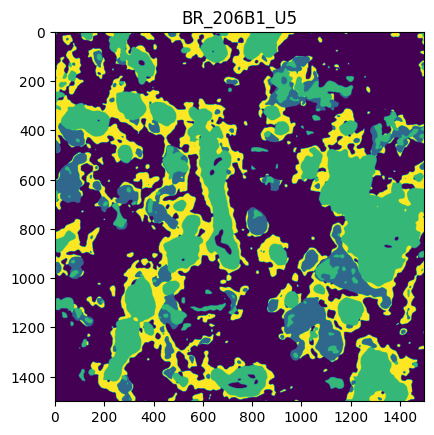

In [16]:
for k, v in sid_to_labeled.items():
    plt.imshow(v)
    plt.title(k)
    plt.show()

In [17]:
x = next(iter(sid_to_labeled.values()))
x

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [29]:
sid_to_img = {}
for sid, labeled in sid_to_labeled.items():
    img = labeled.to(torch.float32)
    img /= img.max()
    img = TF.resize(rearrange(img, 'h w -> 1 1 h w'), (img.shape[-2] // 10, img.shape[-1] // 10))
    sid_to_img[sid] = img


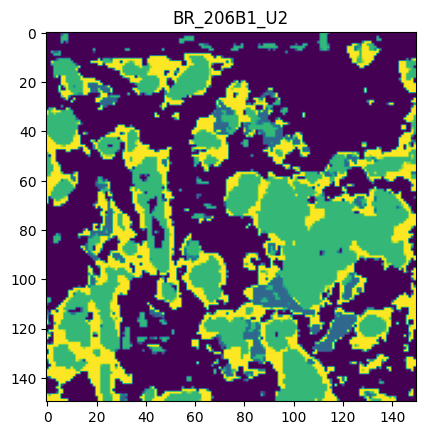

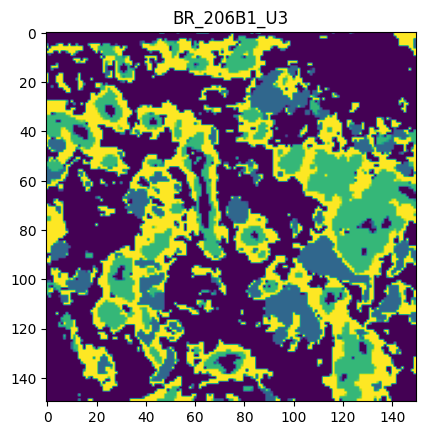

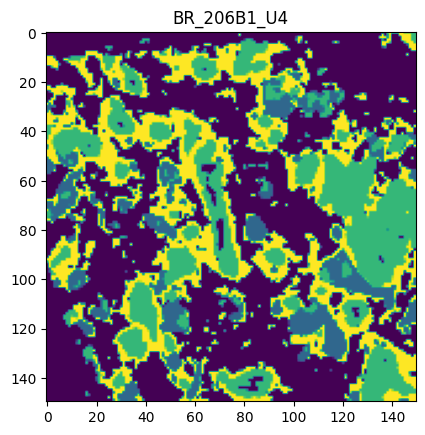

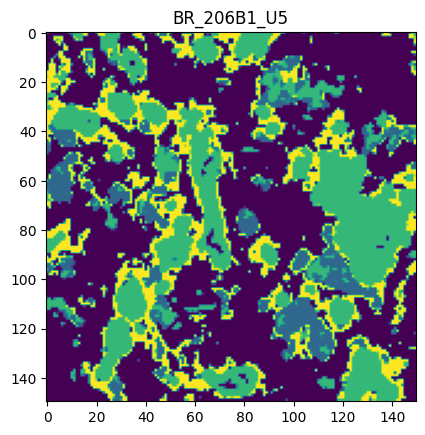

In [30]:
for k, v in sid_to_img.items():
    plt.imshow(v[0, 0])
    plt.title(k)
    plt.show()

In [32]:
sample_order = ['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5']
slices = [sid_to_img[sid] for sid in sample_order]
len(slices)

4

In [31]:
registrator = ImageRegistrator('similarity')

In [47]:
x = registrator.register(slices[0], slices[1])

In [48]:
w = homography_warp(slices[0], x, slices[1].shape[-2:])
w.shape

torch.Size([1, 1, 150, 150])

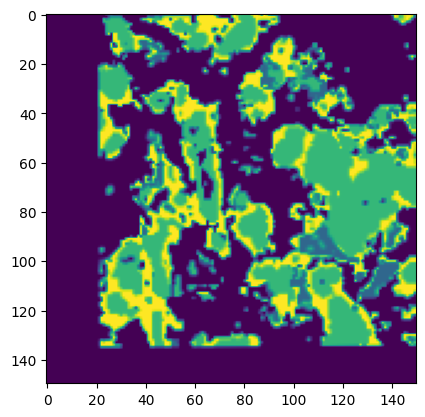

In [49]:
plt.imshow(w[0, 0].detach().numpy())

In [35]:
x

tensor([[[ 1.0362, -0.0053, -0.2634],
         [ 0.0053,  1.0362,  0.1698],
         [ 0.0000,  0.0000,  1.0000]]], grad_fn=<CopySlices>)

In [ ]:
from kornia.geometry import ImageRegistrator
img_src = torch.rand(1, 1, 32, 32)
img_dst = torch.rand(1, 1, 32, 32)
registrator = ImageRegistrator('similarity')
homo = registrator.register(img_src, img_dst)